In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [2]:
msft_df = pd.read_csv('msft.csv')
aapl_df = pd.read_csv('aapl.csv')

## Define the required functions

In [3]:
# Clean the dataframe
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Args:
        df (pd.DataFrame) : dataframe to be cleaned

    Returns:
        df (pd.DataFrame) : cleaned dataframe
    '''
    df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
    df['Open'] = df['Open'].str.replace('$', '').astype(float)
    df['High'] = df['High'].str.replace('$', '').astype(float)
    df['Low'] = df['Low'].str.replace('$', '').astype(float)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.dropna()
    return df

In [4]:
# Compute the volatility for each stock
def calculate_annual_volatility(df):
    '''
    Args:
        df (pd.DataFrame) : dataframe to calculate volatility

    Returns:
        volatility (float) : annualized volatility
    '''
    df["Log_Returns"] = np.log(df["Close/Last"] / df["Close/Last"].shift(1))
    volatility = df["Log_Returns"].std() * np.sqrt(252)  # Annualized volatility
    return volatility

In [5]:
def binomial_option_price(S, K, T, r, sigma, N, option_type="call"):
    '''
    Args:
        S (float) : initial stock price
        K (float) : strike price
        T (float) : time to maturity
        r (float) : risk-free rate
        sigma (float) : volatility
        N (int) : number of time steps
        option_type (str) : call or put option
    
    Returns:
        option_tree[0] (float) : option price
    '''
    dt = T / N  # Time step
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Stock price tree
    stock_tree = np.zeros(N + 1)
    for i in range(N + 1):
        stock_tree[i] = S * (u ** (N - i)) * (d ** i)

    # Option price at maturity
    if option_type == "call":
        option_tree = np.maximum(0, stock_tree - K)
    else:
        option_tree = np.maximum(0, K - stock_tree)

    # Work backward
    for j in range(N - 1, -1, -1):
        option_tree = (p * option_tree[:-1] + (1 - p) * option_tree[1:]) * np.exp(-r * dt)

    return option_tree[0]

In [6]:
def black_scholes(S, K, T, r, sigma, option_type="call"):
    '''
    Args:
        S (float) : initial stock price
        K (float) : strike price
        T (float) : time to maturity
        r (float) : risk-free rate
        sigma (float) : volatility
        option_type (str) : call or put option
    
    Returns:
        option price (float) : option
    '''
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [7]:
# # Calculate implied volatility
# def implied_volatility(S, K, T, r, market_price, option_type="call"):
#     '''
#     Args:
#         S (float) : initial stock price
#         K (float) : strike price
#         T (float) : time to maturity
#         r (float) : risk-free rate
#         market_price (float) : market price of the option
#         option_type (str) : call or put option
    
#     Returns:
#         implied volatility (float) : implied volatility
#     '''
#     func = lambda sigma: black_scholes(S, K, T, r, sigma, option_type) - market_price
    
#     low, high = 0.0001, 5  # Initial range

#     # Expand range if no sign change
#     while func(low) * func(high) > 0 and high < 100:
#         high *= 2  # Expand upper bound exponentially
    
#     try:
#         return brentq(func, low, high)
#     except ValueError:
#         print(f"Could not find implied volatility even after expanding range. Try checking market price.")
#         return None

In [8]:
def delta(S, K, T, r, sigma, option_type="call"):
    '''
    Args:
        S (float) : initial stock price
        K (float) : strike price
        T (float) : time to maturity
        r (float) : risk-free rate
        sigma (float) : volatility
        option_type (str) : call or put option

    Returns:
        delta (float) : delta
    '''
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) if option_type == "call" else norm.cdf(d1) - 1

## Processing Data for each stock

In [9]:
def process_stock(stock_name, df):
    '''
    Args:
        stock_name (str) : stock name
        df (pd.DataFrame) : stock data
    
    Returns:
        None
    '''
    S = df["Close/Last"].iloc[0]  
    sigma = calculate_annual_volatility(df)
    r = 0.05  
    strike_prices = [0.9 * S, S, 1.1 * S]
    maturities = [0.5, 1, 2]
    N = 50

    print(f"\n **Processing {stock_name}**")
    print(f"Stock Price: {S:.2f}, Volatility: {sigma:.4f}, Risk-Free Rate: {r:.2f}")

    bs_prices = []
    binomial_prices = []

    for K in strike_prices:
        for T in maturities:
            binomial_call = binomial_option_price(S, K, T, r, sigma, N, "call")
            bs_call = black_scholes(S, K, T, r, sigma, "call")
            bs_put = black_scholes(S, K, T, r, sigma, "put")
            delta_value = delta(S, K, T, r, sigma, "call")
            put_call_parity = bs_call - bs_put - (S - K * np.exp(-r * T))
            market_price = 10  

            print(f"\nStrike Price: {K:.2f}, Maturity: {T:.1f} years")
            print(f"Binomial Call Price: {binomial_call:.4f}")
            print(f"Black-Scholes Call Price: {bs_call:.4f}, Put Price: {bs_put:.4f}")
            print(f"Put-Call Parity: {put_call_parity:.6f}")
            print(f"Delta (Hedge Ratio): {delta_value:.4f}")

            bs_prices.append(bs_call)
            binomial_prices.append(binomial_call)

    # **Plotting**
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(bs_prices)), bs_prices, marker='o', label="Black-Scholes Price", linestyle="--")
    plt.plot(range(len(binomial_prices)), binomial_prices, marker='s', label="Binomial Model Price")
    plt.xlabel("Option Index")
    plt.ylabel("Call Option Price")
    plt.title(f"Call Option Price Comparison ({stock_name})")
    plt.legend()
    plt.show()
    


 **Processing Microsoft**
Stock Price: 391.26, Volatility: 0.2156, Risk-Free Rate: 0.05

Strike Price: 352.13, Maturity: 0.5 years
Binomial Call Price: 53.9653
Black-Scholes Call Price: 53.9000, Put Price: 6.0798
Put-Call Parity: -0.000000
Delta (Hedge Ratio): 0.8241

Strike Price: 352.13, Maturity: 1.0 years
Binomial Call Price: 67.1020
Black-Scholes Call Price: 67.0334, Put Price: 10.7337
Put-Call Parity: 0.000000
Delta (Hedge Ratio): 0.7963

Strike Price: 352.13, Maturity: 2.0 years
Binomial Call Price: 88.6598
Black-Scholes Call Price: 88.6171, Put Price: 15.9811
Put-Call Parity: 0.000000
Delta (Hedge Ratio): 0.7956

Strike Price: 391.26, Maturity: 0.5 years
Binomial Call Price: 28.5068
Black-Scholes Call Price: 28.6255, Put Price: 18.9652
Put-Call Parity: 0.000000
Delta (Hedge Ratio): 0.5949

Strike Price: 391.26, Maturity: 1.0 years
Binomial Call Price: 43.0176
Black-Scholes Call Price: 43.1852, Put Price: 24.1032
Put-Call Parity: 0.000000
Delta (Hedge Ratio): 0.6330

Strike Pri

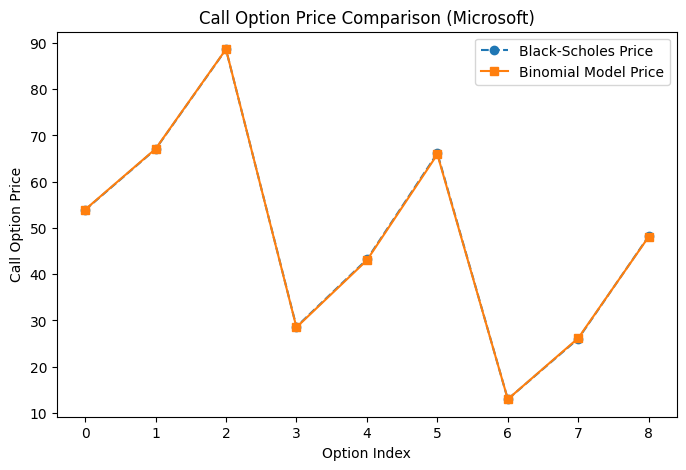


 **Processing Apple**
Stock Price: 218.27, Volatility: 0.2453, Risk-Free Rate: 0.05

Strike Price: 196.44, Maturity: 0.5 years
Binomial Call Price: 31.3001
Black-Scholes Call Price: 31.3070, Put Price: 4.6298
Put-Call Parity: 0.000000
Delta (Hedge Ratio): 0.7991

Strike Price: 196.44, Maturity: 1.0 years
Binomial Call Price: 39.3635
Black-Scholes Call Price: 39.2869, Put Price: 7.8793
Put-Call Parity: -0.000000
Delta (Hedge Ratio): 0.7752

Strike Price: 196.44, Maturity: 2.0 years
Binomial Call Price: 52.0423
Black-Scholes Call Price: 52.1034, Put Price: 11.5824
Put-Call Parity: 0.000000
Delta (Hedge Ratio): 0.7780

Strike Price: 218.27, Maturity: 0.5 years
Binomial Call Price: 17.6720
Black-Scholes Call Price: 17.7470, Put Price: 12.3579
Put-Call Parity: 0.000000
Delta (Hedge Ratio): 0.5913

Strike Price: 218.27, Maturity: 1.0 years
Binomial Call Price: 26.4316
Black-Scholes Call Price: 26.5373, Put Price: 15.8921
Put-Call Parity: -0.000000
Delta (Hedge Ratio): 0.6280

Strike Price: 

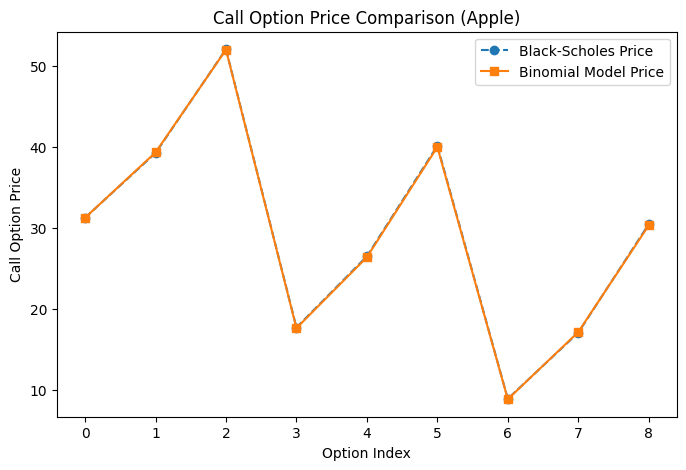

In [10]:
stocks = {"Microsoft": msft_df, "Apple": aapl_df}
for stock_name, df in stocks.items():
    df = clean_dataframe(df)
    process_stock(stock_name, df)